In [3]:

import torch
from torch.utils.data import Dataset
import torchvision.transforms as transforms
from torchvision.datasets import CIFAR10
import random

In [ ]:

#loading the dataset 
import torch.utils
from torch.utils.data import random_split

transform = transforms.Compose([transforms.ToTensor()])
cifar10 = CIFAR10(root='./data', train=True, download=True, transform=transform)
train_size=int(0.8*len(cifar10))
val_size=len(cifar10)- train_size
cfar_train , cfar_val= random_split(cifar10, [train_size, val_size])

class PatchDataset(Dataset):
    def __init__(self, cifar_data, patch_size=10, stride=8):
        self.cifar_data = cifar_data
        self.patch_size = patch_size
        self.stride = stride
        self.position_labels = {
            (0, 0): 0, (0, 1): 1, (0, 2): 2,
            (1, 0): 3,           (1, 2): 4,
            (2, 0): 5, (2, 1): 6, (2, 2): 7
        }

    def __len__(self):
        return len(self.cifar_data)
    # this function allows to extract aone patch from the image 
    def extract_patch(self, img, top, left):
        """Extract a single patch from the image."""
        return img[:, top:top + self.patch_size, left:left + self.patch_size]
    

    def __getitem__(self, idx):
        # loading the image 
        img, _ = self.cifar_data[idx]
        img_size = img.size(1) # get the image size in our case is 32 by 32 

       
        center_top = (img_size - self.patch_size) // 2
        center_left = (img_size - self.patch_size) // 2
        reference_patch = self.extract_patch(img, center_top, center_left)

        
        rel_pos = random.choice(list(self.position_labels.keys()))
        offset_y, offset_x = rel_pos[0] - 1, rel_pos[1] - 1
        neighbor_top = center_top + offset_y * self.stride
        neighbor_left = center_left + offset_x * self.stride
        neighbor_patch = self.extract_patch(img, neighbor_top, neighbor_left)

        
        label = self.position_labels[rel_pos]

        return reference_patch, neighbor_patch, label

 
train_dataset = PatchDataset(cfar_train)
val_dataset=PatchDataset(cfar_val)

train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=128, shuffle=True)
val_loader =torch.utils.data.dataloader = torch.utils.data.DataLoader(val_dataset, batch_size=128, shuffle=True)



image , label =cifar10[0]
print(image.shape)
train_dataset.__getitem__(0)[0].shape






Files already downloaded and verified
torch.Size([3, 32, 32])


torch.Size([3, 10, 10])

In [5]:
for batch_idx, (p1,p2, labels) in enumerate(train_loader):
    # Move each batch to the device
    p1, p2, labels = p1.to("cuda"),p2.to("cuda") ,labels.to("cuda")

In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim

class DualPathCNN(nn.Module):
    def __init__(self):
        super(DualPathCNN, self).__init__()

        self.conv1 = nn.Conv2d(3, 64, kernel_size=5, stride=1, padding=2)
        self.conv2 = nn.Conv2d(64, 128, kernel_size=5, stride=1, padding=2)
        self.conv3 = nn.Conv2d(128, 256, kernel_size=3, stride=1, padding=1)
        self.fc6 = nn.Linear(256 , 512)  #e

        
        self.fc7 = nn.Linear(512 * 2, 256)  # 512*2 since we're concatenating two embeddings
        self.fc8 = nn.Linear(256, 8)  

        # Non-linearities
        self.relu = nn.ReLU()
        self.pool = nn.MaxPool2d(2, 2)
        self.flatten = nn.Flatten()
    
    def shared_cnn(self, x):
        # Pass through the shared CNN layers
        x = self.pool(self.relu(self.conv1(x)))
        x = self.pool(self.relu(self.conv2(x)))
        x = self.relu(self.conv3(x))
        x = self.pool(x)
        x = self.flatten(x)
       
        x = self.relu(self.fc6(x))  # Embedding for each patch
        return x

    def forward(self, patch1, patch2):
        
        embed1 = self.shared_cnn(patch1)
        embed2 = self.shared_cnn(patch2)

        # Concatenate the embeddings for late fusion
        combined = torch.cat((embed1, embed2), dim=1)

        # Pass through fully connected layers for classification
        x = self.relu(self.fc7(combined))
        output = self.fc8(x)  

        return output








In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
train_losses = []
val_losses = []
val_accuracies = []

# Initialize model, loss function, and optimizer
model = DualPathCNN().to("cuda") 
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)
num_epochs = 10
best_val_loss = float('inf')  
for epoch in range(num_epochs):
    # Training phase
    model.train()
    running_train_loss = 0.0
    for patch1, patch2, labels in train_loader:
        optimizer.zero_grad()
        outputs = model(patch1.to("cuda"), patch2.to("cuda"))
        loss = criterion(outputs, labels.to("cuda"))
        loss.backward()
        optimizer.step()
        running_train_loss += loss.item()

    avg_train_loss = running_train_loss / len(train_loader)
    train_losses.append(avg_train_loss)
    print(f"Epoch [{epoch+1}/{num_epochs}], Training Loss: {avg_train_loss:.4f}")

    # Validation phase
    model.eval()
    running_val_loss = 0.0
    correct = 0
    total = 0
    with torch.no_grad():
        for patch1, patch2, labels in val_loader:
            outputs = model(patch1.to("cuda"), patch2.to("cuda"))
            loss = criterion(outputs, labels.to("cuda"))
            running_val_loss += loss.item()

            # Calculate accuracy
            _, predicted = torch.max(outputs, 1)
            total += labels.size(0)
            correct += (predicted == labels.to("cuda")).sum().item()

    # Calculate average validation loss and accuracy
    avg_val_loss = running_val_loss / len(val_loader)
    val_accuracy = 100 * correct / total
    val_losses.append(avg_val_loss)  # Store validation loss
    val_accuracies.append(val_accuracy)  # Store validation accuracy
    print(f"Validation Loss: {avg_val_loss:.4f}, Validation Accuracy: {val_accuracy:.2f}%")

    # Save the model if it has the best validation loss
    if avg_val_loss < best_val_loss:
        best_val_loss = avg_val_loss
        torch.save(model.state_dict(), 'best_model.pth')
        print(f"Saved Best Model with Validation Loss: {best_val_loss:.4f}")


Epoch [1/10], Training Loss: 2.0051
Validation Loss: 1.9535, Validation Accuracy: 18.87%
Saved Best Model with Validation Loss: 1.9535
Epoch [2/10], Training Loss: 1.8729
Validation Loss: 1.7006, Validation Accuracy: 28.50%
Saved Best Model with Validation Loss: 1.7006
Epoch [3/10], Training Loss: 1.6000
Validation Loss: 1.5261, Validation Accuracy: 37.82%
Saved Best Model with Validation Loss: 1.5261
Epoch [4/10], Training Loss: 1.4954
Validation Loss: 1.4858, Validation Accuracy: 40.22%
Saved Best Model with Validation Loss: 1.4858
Epoch [5/10], Training Loss: 1.4506
Validation Loss: 1.4130, Validation Accuracy: 41.32%
Saved Best Model with Validation Loss: 1.4130
Epoch [6/10], Training Loss: 1.4221
Validation Loss: 1.5094, Validation Accuracy: 36.95%
Epoch [7/10], Training Loss: 1.4048
Validation Loss: 1.4880, Validation Accuracy: 39.18%
Epoch [8/10], Training Loss: 1.3186
Validation Loss: 1.2226, Validation Accuracy: 52.21%
Saved Best Model with Validation Loss: 1.2226
Epoch [9/10]

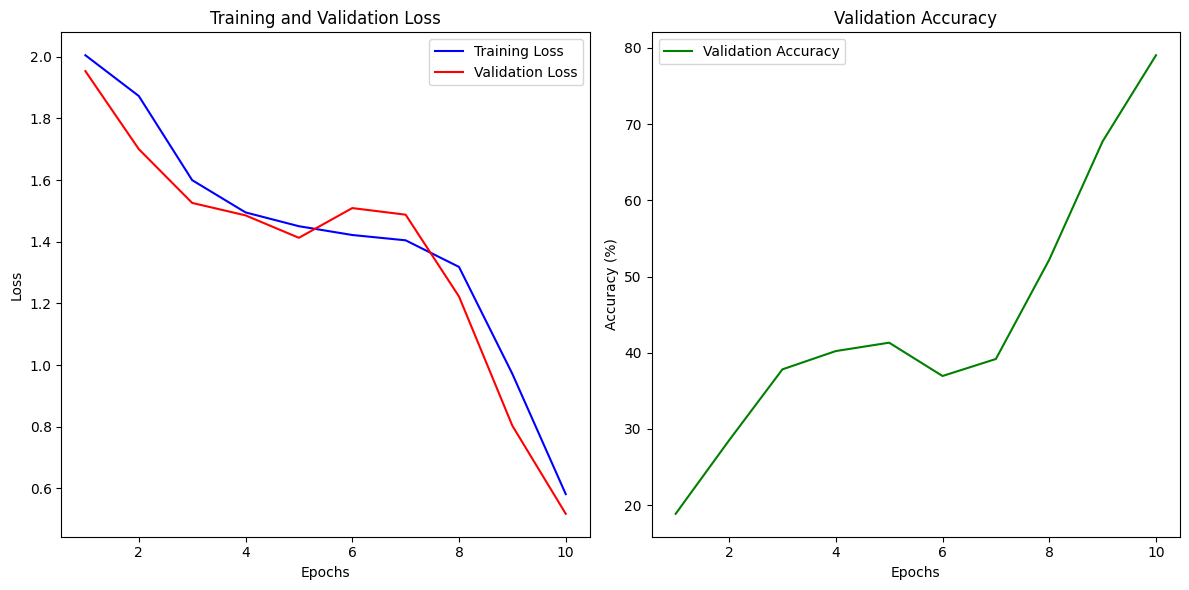

In [10]:
# Plotting Training and Validation Loss
import matplotlib.pyplot as plt 
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.plot(range(1, num_epochs+1), train_losses, label='Training Loss', color='blue')
plt.plot(range(1, num_epochs+1), val_losses, label='Validation Loss', color='red')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Training and Validation Loss')
plt.legend()

# Plotting Validation Accuracy
plt.subplot(1, 2, 2)
plt.plot(range(1, num_epochs+1), val_accuracies, label='Validation Accuracy', color='green')
plt.xlabel('Epochs')
plt.ylabel('Accuracy (%)')
plt.title('Validation Accuracy')
plt.legend()

plt.tight_layout()
plt.show()
